In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from librosa.display import specshow #### pip install librosa
import seaborn as sns
import os
import numpy as np
import pandas as pd
import glob
from os import listdir
from os.path import isfile, join
from sklearn.preprocessing import MinMaxScaler
import re
from skimage.transform import resize
from functools import reduce

from data.spectrogram import *
from data import *

In [8]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)
import shutup; shutup.please() ## pip install shutup

In [9]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed = 2555304
seed_everything(seed)


# # gpu setting
# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = DEVICE
# torch.cuda.set_device(DEVICE)

# importing data from filepath ***** INITIAL SPECTROGRAM DATA RESHAPED to (224,224) and NORMALISED in "import_pair_data" function

In [10]:
# modality directory names (SAME MODALITY - PWR)
naming1      =  'exp_15_pwr_spectrograms'   
naming2      =  'exp_15_pwr_spectrograms'   
naming3      =  'exp_15_pwr_spectrograms' 

load_dir1    = 'experiment_data/'+ naming1 +'/' +'spectrogram_multi'                
load_dir2    = 'experiment_data/'+ naming2 +'/' +'spectrogram_multi'         
load_dir3    = 'experiment_data/'+ naming3 +'/' +'spectrogram_multi'         

directory = [load_dir1, load_dir2, load_dir3]
modal     = [ 'PWR_ch1',   'PWR_ch2',   'PWR_ch3'] 

print("Data to be imported from directory: \n {} \n for nodes: \n {} ".format(directory, modal ))

datas       = import_four_modality_wificsi_data( directory , modal ,return_id=True,skip_bad_data=True)  

# #############################################################################################################
 
# # modality directory names (SAME MODALITY - WiFi)
# naming1      =  'exp_10_amp_spec_only_STFT'   #nuc1 and nuc2
# naming2      =  'exp_10_amp_spec_only_STFT'   #nuc1 and nuc2

# load_dir1    = 'experiment_data/'+ naming1 +'/' +'spectrogram_multi'                
# load_dir2    = 'experiment_data/'+ naming2 +'/' +'spectrogram_multi'         

# directory = [load_dir1, load_dir2]
# modal     = [ 'nuc1',   'nuc2'] 

# print("Data to be imported from directory: \n {} \n for nodes: \n {} ".format(directory, modal ))

# datas       = import_four_modality_wificsi_data( directory , modal ,return_id=True,skip_bad_data=True)  

# #############################################################################################################

# # modality directory names (DIFFERENT MODALITIES - WiFi and PWR)
# naming1      =  'exp_15_pwr_spectrograms'   #nuc1 and nuc2
# naming2      =  'exp_10_amp_spec_only_STFT'   #nuc1 and nuc2

# load_dir1    = 'experiment_data/'+ naming2 +'/' +'spectrogram_multi'                
# load_dir3    = 'experiment_data/'+ naming1 +'/' +'spectrogram_multi'                
# load_dir4    = 'experiment_data/'+ naming1 +'/' +'spectrogram_multi'     
# load_dir5    = 'experiment_data/'+ naming1 +'/' +'spectrogram_multi'     


# directory = [load_dir1, load_dir3, load_dir4,load_dir5]
# modal     = [ 'nuc1', 'PWR_ch1',   'PWR_ch2',   'PWR_ch3'] 

# print("Data to be imported from directory: \n {} \n for nodes: \n {} ".format(directory, modal ))

# datas       = import_four_modality_wificsi_data( directory , modal ,return_id=True,skip_bad_data=True)  

Data to be imported from directory: 
 ['experiment_data/exp_15_pwr_spectrograms/spectrogram_multi', 'experiment_data/exp_15_pwr_spectrograms/spectrogram_multi', 'experiment_data/exp_15_pwr_spectrograms/spectrogram_multi'] 
 for nodes: 
 ['PWR_ch1', 'PWR_ch2', 'PWR_ch3'] 
Importing Data >>>>>> Complete


# filtering activities --> skip any activity data if desired and do train-test split according to chosen validation method)

In [11]:
if len(modal)==4:
    X1,X2,X3,X4, y,person_id, room_id, exp_num = initial_filtering_activities(datas,activities=[])
if len(modal)==3:
    X1,X2,X3, y,person_id, room_id, exp_num = initial_filtering_activities(datas,activities=[])
elif len(modal)==2:
    X1,X2,y,person_id, room_id, exp_num = initial_filtering_activities(datas,activities=[])

del datas       


val_method    =  'random'                  # validation method; option:   'personid' ,  'roomid', 'expid'  ,  'random'


room_df   = pd.DataFrame(room_id, columns=["room_id"])
person_df = pd.DataFrame(person_id, columns=["person_id"])

### replace strings by numbers for room_id and person_id

room_df.room_id[room_df.room_id == '1'] = 1
room_df.room_id[room_df.room_id == '2'] = 2

person_df.person_id[person_df.person_id == 'One']     = 1
person_df.person_id[person_df.person_id == 'Two']     = 2
person_df.person_id[person_df.person_id == 'Three']   = 3
person_df.person_id[person_df.person_id == 'Four']    = 4
person_df.person_id[person_df.person_id == 'Five']    = 5
person_df.person_id[person_df.person_id == 'Six']     = 6
person_df.person_id[person_df.person_id == 'Seven']   = 7


### CHOOSE WHICH ROOM or PERSON or EXP_NO TO USE AS TEST DATA

if val_method == 'personid':
    validation_id  = 1     # 1,2,3,4,5,6,7#### person_id: 'One', 'Two' , 'Three', 'Four' , 'Five', 'Six' , 'Seven'
    id_ls = np.array(person_df['person_id']).astype(str).astype(int)

elif val_method == 'roomid':
    validation_id  = 2    #1,2 #  room_id: '1' , '2'    
    id_ls = np.array(room_df['room_id']).astype(str).astype(int)    

elif val_method == 'expid':
    validation_id = 7    #1,2 #  exp_id: '1' , '2' , '3'  corresponding to exp001, exp002, exp003, etc    
    id_ls         =  exp_num

In [12]:
if len(modal)==4:
    if val_method == 'personid':
        X1_train, X1_test, X2_train, X2_test, X3_train, X3_test, X4_train, X4_test, y_train_, y_test_ = split_datasets_quad_data(X1,X2,X3,X4,y,by='personid',id_ls=id_ls,validation_id=validation_id)

    elif val_method == 'roomid':
        X1_train, X1_test, X2_train, X2_test, X3_train, X3_test, X4_train, X4_test, y_train_, y_test_ = split_datasets_quad_data(X1,X2,X3,X4,y,by='roomid',id_ls=id_ls,validation_id=validation_id)

    elif val_method == 'expid':
        X1_train, X1_test, X2_train, X2_test, X3_train, X3_test, X4_train, X4_test, y_train_, y_test_ = split_datasets_quad_data(X1,X2,X3,X4,y,by='expid',id_ls=id_ls,validation_id=validation_id)

    else:
        X1_train, X1_test, X2_train, X2_test, X3_train, X3_test, X4_train, X4_test, y_train_, y_test_ = split_datasets_quad_data(X1,X2,X3,X4,y,by='random',split=0.8,stratify=y)

    del X3
    del X4

elif len(modal)==2:    
    if val_method == 'personid':
        X1_train, X1_test, X2_train, X2_test, y_train_, y_test_ = split_datasets(X1,X2,y,by='personid',id_ls=id_ls,validation_id=validation_id)

    elif val_method == 'roomid':
        X1_train, X1_test, X2_train, X2_test, y_train_, y_test_ = split_datasets(X1,X2,y,by='roomid',id_ls=id_ls,validation_id=validation_id)

    elif val_method == 'expid':
        X1_train, X1_test, X2_train, X2_test, y_train_, y_test_ = split_datasets(X1,X2,y,by='expid',id_ls=id_ls,validation_id=validation_id)

    elif val_method == 'random':
        X1_train, X1_test, X2_train, X2_test, y_train_, y_test_ = split_datasets(X1,X2,y,by='random',split=0.8,stratify=y)
               
 
elif len(modal)==3:
    if val_method == 'personid':
        X1_train, X1_test, X2_train, X2_test, X3_train, X3_test, y_train_, y_test_ = split_datasets_triple_data(X1,X2,X3,y,by='personid',id_ls=id_ls,validation_id=validation_id)

    elif val_method == 'roomid':
        X1_train, X1_test, X2_train, X2_test, X3_train, X3_test, y_train_, y_test_ = split_datasets_triple_data(X1,X2,X3,y,by='roomid',id_ls=id_ls,validation_id=validation_id)

    elif val_method == 'expid':
        X1_train, X1_test, X2_train, X2_test, X3_train, X3_test, y_train_, y_test_ = split_datasets_triple_data(X1,X2,X3,y,by='expid',id_ls=id_ls,validation_id=validation_id)

    else:
        X1_train, X1_test, X2_train, X2_test, X3_train, X3_test, y_train_, y_test_ = split_datasets_triple_data(X1,X2,X3,y,by='random',split=0.8,stratify=y)

    del X3
        

In [13]:
print('X1 train shape:',X1_train.shape, 'X1 test shape:' ,X1_test.shape ) ## 1 channel image data, size of image = 224x224

X1 train shape: (2027, 1, 224, 224) X1 test shape: (507, 1, 224, 224)


<Figure size 640x480 with 0 Axes>

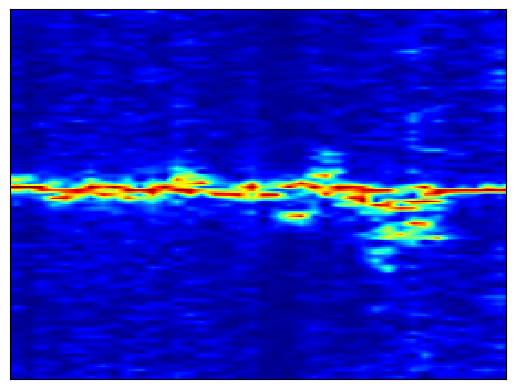

<Figure size 640x480 with 0 Axes>

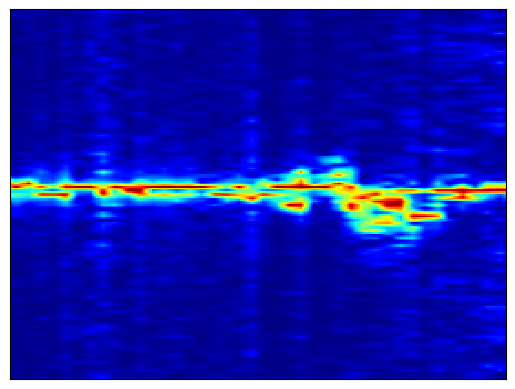

<Figure size 640x480 with 0 Axes>

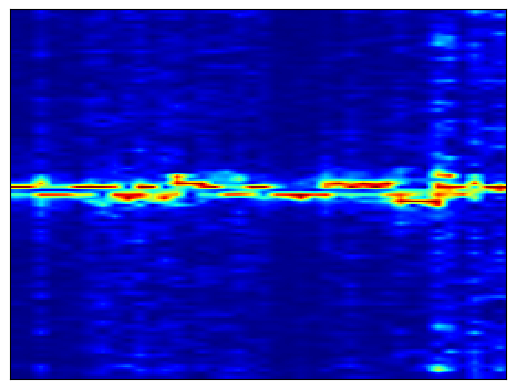

In [14]:
### DISPLAY DATA FROM 2 RECEIVERS
timepoint = 55
plt.figure()
plt.show()
specshow(np.squeeze(X1_train[ timepoint,:,:])  ,cmap="jet")

plt.figure()
plt.show()
specshow(np.squeeze(X2_train[ timepoint,:,:])  ,cmap="jet")


if len(modal)==4:
    plt.figure()
    plt.show()
    specshow(np.squeeze(X3_train[ timepoint,:,:])  ,cmap="jet")

    plt.figure()
    plt.show()
    specshow(np.squeeze(X4_train[ timepoint,:,:])  ,cmap="jet")

elif len(modal)==3:
    plt.figure()
    plt.show()
    specshow(np.squeeze(X3_train[ timepoint,:,:])  ,cmap="jet")

In [25]:
import pickle

fileList  = [
    'X1_train.pkl','X2_train.pkl','X3_train.pkl',
    'X1_test.pkl','X2_test.pkl','X3_test.pkl',
    'y_train_.pkl','y_test_.pkl'
]
varNames = [
    'X1_train','X2_train','X3_train',
    'X1_test','X2_test','X3_test',
    'y_train_','y_test_'
]

assert len(fileList) == len(varNames)

for name, fname in zip(varNames, fileList):
    obj = globals()[name]
    with open(fname, 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
